In [1]:
import fastai

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
from sklearn.metrics import mean_squared_error as sk_mse

from fastai.learner import Learner
from fastai.metrics import rmse
from fastai.tabular.model import get_emb_sz
from fastai.tabular.all import *

from dies.data import tp_from_df, get_y_ranges, split_by_year, create_consistent_number_of_sampler_per_day, TimeseriesTransform
from dies.utils_pytorch import xavier_init_uniform
from dies.autoencoder import VariationalAutoencoder
from dies.losses import VAEReconstructionLoss
from dies.data import *
from dies.embedding import EmbeddingModule
from dies.data import split_by_year

%load_ext autoreload
%autoreload 2
sns.set_context('poster')
sns.set_style('whitegrid')
mpl.rcParams["legend.loc"] = 'upper right'

In [2]:
with pd.HDFStore('./data/GEFCOM_Z1.h5') as store:
    df = store['powerdata']

In [3]:
df = df.fillna(df.mean())
df = df.dropna(axis=1)

In [4]:
df.TimeUTC = pd.to_datetime(df.TimeUTC, infer_datetime_format=True, utc=True)
df.set_index('TimeUTC', inplace=True)
df.PowerGeneration = df.PowerGeneration.apply(float) / df.MaxPowerGeneration.apply(float)
df.drop('MaxPowerGeneration', axis=1, inplace=True)

In [5]:
df['DayOfYear'] = df.index.dayofyear
df['Hour'] = df.index.hour

In [6]:
cols = [ 'WindDirectionMeridional100m',
       'WindDirectionMeridional10m', 'WindDirectionZonal100m',
       'WindDirectionZonal10m', 'WindSpeed100m', 'WindSpeed10m']

cat_cols = ['DayOfYear', 'Hour']

df_train, df_test  = split_by_year(df, year="2013")

tp = tp_from_df(df_train, y_columns=cols, x_columns=cols, 
                cat_columns = cat_cols, 
                standardize_X=True,
                valid_percent=0.2)

/home/scribbler/anaconda/lib/python3.8/site-packages/fastai/tabular/core.py:148: UserWarning: Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.
  warn("Using inplace with splits will trigger a pandas error. Set `pd.options.mode.chained_assignment=None` to avoid it.")


In [7]:
dl = tp.dataloaders(bs=128)

In [8]:
input_size = tp.conts.shape[1]
sizes_cat = [367, 25]
ann_structure = [input_size, 50, 10, 3]

In [9]:
embedding_module = EmbeddingModule(sizes_cat, embedding_dropout=0.1)

ann_model = VariationalAutoencoder(
    ann_structure=ann_structure,
    embedding_module=embedding_module,
    embeding_position="start",
    y_ranges=get_y_ranges(dl.train_ds.ys),
)

In [10]:
learn = Learner(
    dl,
    ann_model,
    loss_func=VAEReconstructionLoss(ann_model),
)


In [11]:
learn.fit_one_cycle(10, lr_max=0.1)

epoch,train_loss,valid_loss,time
0,0.844526,0.887138,00:00
1,0.333790,0.284982,00:00
2,0.172374,0.132960,00:00
3,0.116416,0.154829,00:00
4,0.091613,0.075227,00:00
5,0.068635,0.057529,00:00
6,0.060790,0.042204,00:00
7,0.054604,0.022562,00:00
8,0.044253,0.020850,00:00
9,0.041377,0.021200,00:00


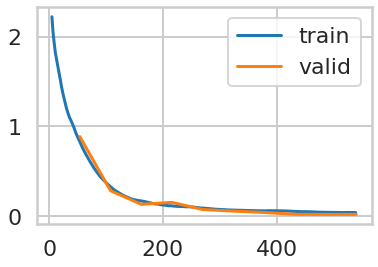

In [12]:
learn.recorder.plot_loss()